In [1146]:
# Import necessary libraries 
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from sklearn.preprocessing import LabelEncoder
import spacy
import string
from nltk.corpus import stopwords
from nltk.probability import FreqDist
import warnings
warnings.filterwarnings('ignore')

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Conv1D,Dense,Embedding,MaxPooling1D,GlobalMaxPooling1D,Input
from keras.models import Model
from wordcloud import WordCloud

In [1147]:
nltk.download("stopwords") #download nltk 

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ahame\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [1229]:
# Import the dataset as csv using pandas and remove unwanted columns
dataset= pd.read_csv("./data/sms_spam_ham.csv",encoding='latin-1') 
dataset.drop(columns=[
    'Unnamed: 2',
    'Unnamed: 3',
    'Unnamed: 4',
] , inplace=True)
dataset.head(20)

,label,review
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
5,spam,FreeMsg Hey there darling it's been 3 week's n...
6,ham,Even my brother is not like to speak with me. ...
7,ham,As per your request 'Melle Melle (Oru Minnamin...
8,spam,WINNER!! As a valued network customer you have...
9,spam,Had your mobile 11 months or more? U R entitle...


In [1149]:
dataset.describe()

,label,review
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


In [1150]:
dataset.info()  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   5572 non-null   object
 1   review  5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [1151]:
dataset.groupby('label').describe()

review                                                               
       count unique                                                top freq
label                                                                      
ham     4825   4516                             Sorry, I'll call later   30
spam     747    653  Please call our customer service representativ...    4

In [1152]:
dataset['length'] = dataset['review'].apply(len) # add a length column for get the length of each review texts

In [1153]:
dataset.head()

,label,review,length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


In [1156]:
label_encoder = LabelEncoder()

In [1157]:
dataset['label'] = label_encoder.fit_transform(dataset['label']) # add Label encoding to target column 

In [1158]:
dataset['label']

0       0
1       0
2       1
3       0
4       0
       ..
5567    1
5568    0
5569    0
5570    0
5571    0
Name: label, Length: 5572, dtype: int32

In [1159]:
## Correlation
dataset.corr()

,label,length
label,1.000000,0.387285
length,0.387285,1.000000


## Data Visualization

<Axes: ylabel='Frequency'>

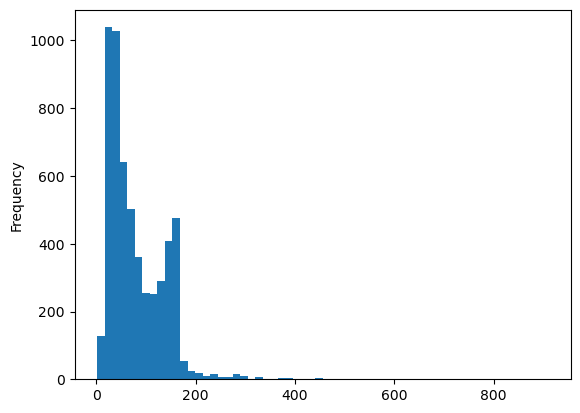

In [1160]:
dataset['length'].plot.hist(bins=60)

In [1161]:
dataset['length'].describe()

count    5572.000000
mean       80.118808
std        59.690841
min         2.000000
25%        36.000000
50%        61.000000
75%       121.000000
max       910.000000
Name: length, dtype: float64

array([<Axes: title={'center': '0'}>, <Axes: title={'center': '1'}>],
      dtype=object)

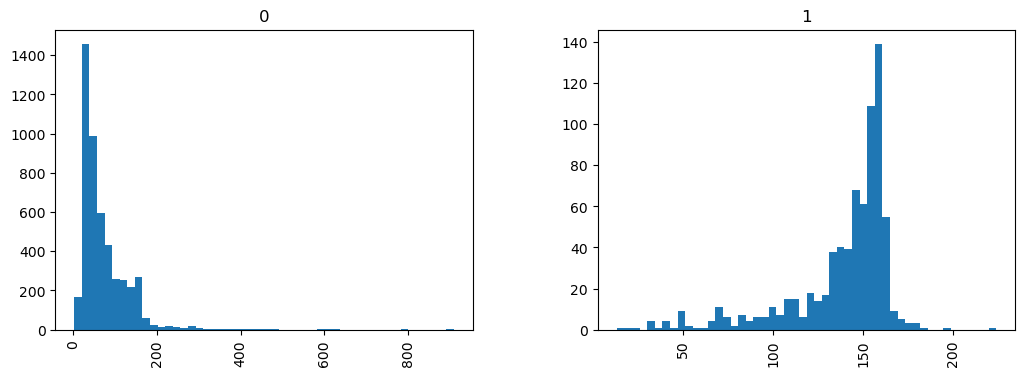

In [1162]:
dataset.hist(column='length',by='label',bins=50,figsize=(12,4))

<Axes: xlabel='label', ylabel='length'>

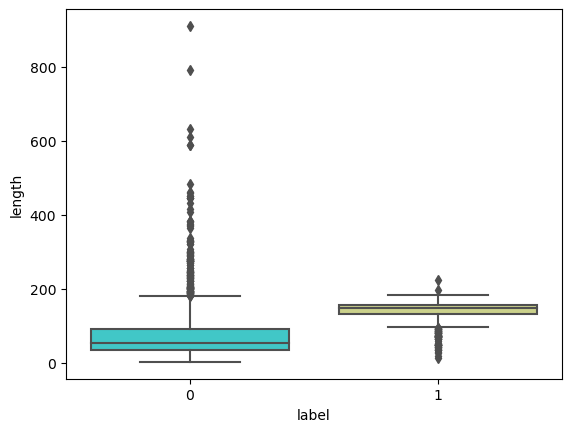

In [1163]:
sns.boxplot(x='label',y='length',data=dataset,palette='rainbow')

<Axes: xlabel='label', ylabel='count'>

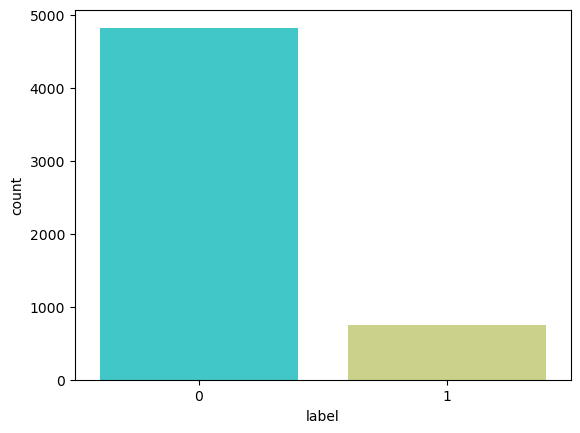

In [1164]:
sns.countplot(x='label',data=dataset,palette='rainbow')

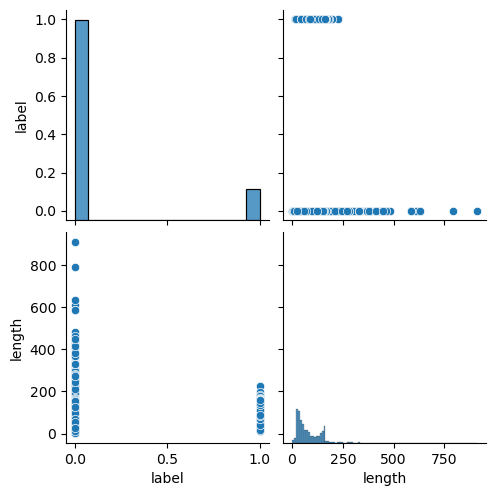

In [1165]:
sns.pairplot(dataset)

## Data Cleaning

In [1166]:
# Checking for NaN values
dataset.isnull().sum()

label     0
review    0
length    0
dtype: int64

In [1167]:
# Checking for empty whitespace strings and assign for an array 
empty_list = []  

for i,label,review,length in dataset.itertuples():  # iterate over the DataFrame
    if type(review)==str:           
        if review.isspace():         
            empty_list.append(i)    
        
len(empty_list)

0

In [1168]:
#droping NaN values
dataset.dropna(inplace=True)

In [1169]:
#drop empty space values in review 
dataset.drop(empty_list,inplace=True)

In [1170]:
# Checking for duplicate values
dataset.duplicated().sum()

403

In [1171]:
#remove duplicate entries
dataset.drop_duplicates(keep='first',inplace=True)

In [1172]:
dataset.groupby('label').describe()

length                                                         
        count        mean        std   min    25%    50%    75%    max
label                                                                 
0      4516.0   70.459256  56.358207   2.0   34.0   52.0   90.0  910.0
1       653.0  137.891271  30.137753  13.0  132.0  149.0  157.0  224.0

In [1173]:
#identify the important punctuations
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [1174]:
#load english vocabulary
nlp_load = spacy.load("en_core_web_sm")


In [1175]:
nlp_load.max_length = 200000

In [1176]:
#Create a function to identify the punctuations in each words
def separate_puncuation(doc_text):
    return [token for token in nlp_load(doc_text) if token.text not in '\n\n \n\n\n!"-#$%&()--.*+,-/:;<=>?@[\\]^_`{|}~\t\n ']


In [1177]:
#check wheter there are any single puncuations and convert the row to string
def remove_punctuation_and_convert_to_string(token):
    return ''.join(char for char in str(token) if char not in string.punctuation)

In [1178]:
#remove stopwords from each row
def remove_stopwords(token):
    return [word for word in token.split() if word.lower() not in stopwords.words('english')]

In [1179]:
#convert each tokens to string after removing stopwords
def join_list_to_string(lst):
    return ' '.join(lst)

In [1180]:
dataset['review'] = dataset['review'].apply(separate_puncuation)

In [1181]:
dataset['review'] = dataset['review'].apply(remove_punctuation_and_convert_to_string)

In [1182]:
dataset['review'] = dataset['review'].apply(remove_stopwords)

In [1183]:
dataset['review'] = dataset['review'].apply(lambda x: join_list_to_string(x))

In [1184]:
dataset['review'] 

0       Go jurong point crazy Available bugis n great ...
1                                 Ok lar Joking wif u oni
2       Free entry 2 wkly comp win FA Cup final tkts 2...
3                     U dun say early hor U c already say
4               Nah nt think goes usf lives around though
                              ...                        
5567    2nd time tried 2 contact u U å£750 Pound prize...
5568                          Ì b going esplanade fr home
5569                                Pity mood suggestions
5570    guy bitching acted like interested buying some...
5571                                       Rofl true name
Name: review, Length: 5169, dtype: object

In [1185]:
#get the values of target data from dataset
target = dataset['label'].values

In [1186]:
#get the values of taining data from dataset
train =dataset['review'].values

In [1187]:
target.shape

(5169,)

In [1188]:
# remove all puctuations (train data)
# remove all stopwords
# create a key value pair for word and vector an store 

token_response = []
word2vec={}
for text in train:
    print(text)
    tokens = separate_puncuation(text)
    for x in tokens:
        rem_punc = [single_letter for single_letter in x.text if single_letter not in string.punctuation]
        word=''.join(rem_punc)
        if word.lower() not in stopwords.words('english') :
            vec=np.asarray(x.vector,dtype='float32')
            word2vec[word]=vec
    token_response.append(tokens)
  


Go jurong point crazy Available bugis n great world la e buffet Cine got amore wat
Ok lar Joking wif u oni
Free entry 2 wkly comp win FA Cup final tkts 21st May 2005 Text FA 87121 receive entry questionstd txt rateTC apply 08452810075over18
U dun say early hor U c already say
Nah nt think goes usf lives around though
FreeMsg Hey darling 3 week word back like fun still Tb ok XxX std chgs send å£150 rcv
Even brother like speak treat like aids patent
per request Melle Melle Oru Minnaminunginte Nurungu Vettam set callertune Callers Press 9 copy friends Callertune
WINNER valued network customer selected receivea å£900 prize reward claim call 09061701461 Claim code KL341 Valid 12 hours
mobile 11 months U R entitled Update latest colour mobiles camera Free Call Mobile Update Co FREE 08002986030
gon na home soon nt want talk stuff anymore tonight k cried enough today
SIX chances win CASH 100 20000 pounds txt CSH11 send 87575 Cost 150p day 6days 16 TsandCs apply Reply HL 4 info
URGENT 1 week FR

PLS STOP bootydelious 32 F inviting friend Reply YES434 NO434 See wwwSMSacubootydelious STOP Send STOP FRND 62468
BangBabes Ur order way U receive Service Msg 2 download UR content U GoTo wap bangb tv UR mobile internet service menu
place ur points e cultures module already
URGENT trying contact Last weekends draw shows å£900 prize GUARANTEED Call 09061701939 Claim code S89 Valid 12hrs
Hi frnd best way avoid missunderstding wit beloved one
Great escape fancy bridge needs lager See tomo
Yes completely formclark also utter waste
Sir need AXIS BANK account bank address
Hmmm Thk sure got time hop ard Ya go 4 free abt Muz call u discuss liao
time coming later
Bloody hell ca nt believe forgot surname Mr Ill give u clue spanish begins
Well gon na finish bath good fine night
Let know got money carlos make call
U still going mall
Turns friends staying whole show wo nt back til ltgt feel free go ahead smoke ltgt worth
Text nt reply let know log
Hi spoke MANEESHA V like know satisfied experience 

Call Germany 1 pence per minute Call fixed line via access number 0844 861 85 85 prepayment Direct access
chance might evaporated soon violated privacy stealing phone number employer paperwork cool Please contact report supervisor
Valentines Day Special Win å£1000 quiz take partner trip lifetime Send GO 83600 150p msg rcvd CustCare08718720201
Ta Daaaaa home babe still
Cool come nt wined dined
sleeping surfing
U calling right Call hand phone
Ok great thanx lot
take post come must 1000s texts Happy reading one wiv hello caroline end favourite Bless
u hiding stranger
interested like
sister cleared two round birla soft yesterday
Gudnite tc practice going
Dis yijue jus saw ur mail case huiming nt sent u num Dis num
One small prestige problem
Fancy shag Interested sextextukcom txt XXUK SUZY 69876 Txts cost 150 per msg TnCs website X
checking Really miss seeing Jeremiah great month
Nah ca nt help never iphone
car hour half going apeshit
TODAY Sorry day ever angry ever misbehaved hurt plz plz 

Got meh
Nope Think go monday Sorry replied late
told accenture confirm true
Kate jackson rec center 7ish right
Dear reache room
Fighting world easy u either win lose bt fightng some1 close u dificult u lose u lose u win u still lose
Ì come
Check nuerologist
Lolnice went fish water
123 Congratulations week competition draw u å£1450 prize claim call 09050002311 b4280703 TCs stop SMS 08718727868 18 150ppm
waiting e car dat bored wat Cos wait outside got nothing 2 home stuff watch tv wat
Maybe westshore hyde park village place near house
know anthony bringing money school fees pay rent stuff like need help friend need
significance
opinion 1 2 Jada 3 Kusruthi 4 Lovable 5 Silent 6 Spl character 7 matured 8 Stylish 9 Simple Pls reply
8 latest g still scrounge ammo want give new ak try
Prabha im soryda realy frm heart sory
Lol ok forgiven
jst change tat
guaranteed latest Nokia Phone 40 GB iPod MP3 player å£500 prize Txt word COLLECT 83355 IBHltd LdnW15H 150p Mtmsgrcvd18
Sno competition
Boltblu

Ditto wo nt worry saying ANYTHING anymore Like said last night whatever want Peace
got ltgt way could pick
nt knw pa drink milk
Maybe Say hi find got card Great escape wetherspoons
Piggy r u awake bet ure still sleeping going 4 lunch
Cause freaky lol
Missed call cause yelling scrappy Miss u Ca nt wait u come home lonely today
hex place talk Explain
ÌÏ log 4 wat sdryb8i
xy going 4 e lunch
Hi sue 20 years old work lapdancer love sex Text live bedroom text SUE 89555 TextOperator G2 1DA 150ppmsg 18
wanted ask Ì wait 4 finish lect Cos lect finishes hour anyway
finished work yet
Every King Crying Baby Every Great Building Map Imprtant U r TODAY U Wil Reach TOMORW Gud ni8
Dear cherthalain case u r coming cochin pls call bfore u starti shall also reach accordinglyor tell day u r comingtmorow engaged ans holiday
Thanks love torch bold
Forwarded 448712404000 Please CALL 08712404000 immediately urgent message waiting
farm open
Sorry trouble u buy 4d dad 1405 1680 1843 2 big 1 small sat n sun Than

tried contact offer New Video Phone 750 anytime network mins HALF PRICE Rental camcorder call 08000930705 reply delivery
Last chance 2 claim ur å£150 worth discount vouchers Text YES 85023 nowSavaMob member offers mobile Cs 08717898035 å£300 Sub 16 Remove txt X STOP
luv u soo much u donåÕt understand special u r 2 ring u 2morrow luv u xxx
Pls send comprehensive mail paying much
Prashanthettan mother passed away last night pray family
Urgent call 09066350750 landline complimentary 4 Ibiza Holiday 10000 cash await collection SAE TCs PO BOX 434 SK3 8WP 150 ppm 18
Kkwhen going
Meanwhile shit suite xavier decided give us ltgt seconds warning samantha coming playing jay guitar impress shit Also nt think doug realizes nt live anymore
stomach thru much trauma swear ca nt eat better lose weight
officewhats matter msg nowi call break
Yeah barely enough room two us x many fucking shoes Sorry man see later
U reach orchard already U wan 2 go buy tickets first
real baby want bring inner tigress
da r

Ugh Got ta drive back sd la butt sore
26th JULY
Hi relaxing time ever get 7 every day party good night get home tomorrow 5ish
Ì ÌÏ wan come come lor din c stripes skirt
Xmas story peace Xmas msg love Xmas miracle jesus Hav blessed month ahead amp wish U Merry Xmas
ca nt nt number
Change e one next escalator
Yetunde class run water make ok Pls
lot happened Feels quiet Beth aunts charlie working lots helen mo
Ì wait 4 bus stop aft ur lect lar dun c Ì go get car come back n pick Ì
Aight thanks comin
heard abt tat
ltgt think say syllabus
Umma say anything
Give sec think think
Panasonic BluetoothHdset FREE Nokia FREE Motorola FREE DoubleMins DoubleTxt Orange contract Call MobileUpd8 08000839402 call 2optout
nt quite know still ca nt get hold anyone cud pick bout 730pm see pub
Poyyarikatur kolathupalayam unjalur post erode dis ltgt
Dear Hero leaving qatar tonite apt opportunitypls keep touch ltEMAILgt kerala
Lol would mom would fit tell whole family crazy terrible
got home babe still awake
d

u find sitter kaitlyn sick slept day yesterday
Sorry man accidentally left phone silent last night nt check til got
Hey Something came last min Think wun signing tmr Hee
adult would learn experience real danger nt like peeps using drugs nt need comment
Hey veggie pizza
Yun buying school got offer 2000 plus
sure neighbors nt pick
K sent
Well computerless Time make oreo truffles
Haha yeah see sec
number sir
Lol hot air balloon
Ok bus come soon come otherwise tomorrow
Msgs r time pass silently say thinking U right also making U think least 4 moment Gd ntswt drms Shesil
Yeah probably swing roommate finishes girl
Got takes 2 take part WRC Rally Oz U Lucozade Energy Text RALLY LE 61200 25p see packs lucozadecoukwrc itcould u
Happy new years melody
ÌÏ dun need pick ur gf
Yay better told 5 girls either
Horrible u eat macs eat u forgot abt already rite U take long 2 reply thk toot b4 b prepared wat shall eat
say fantastic chance anything need bigger life lift losing 2 live think would first per

Aight sorry take ten years shower plan
Every monday nxt week vl completing
Might ax well
chill another 6hrs could sleep pain surgical emergency see unfolds Okay
Yeah try scrounge something
Crazy ar married ÌÏ like gd looking guys frens like say korean leona fave dun thk Aft thinking mayb prob go
somewhere Fredericksburg
Que pases un buen tiempo something like
ok stay night Xavier sleeping bag getting tired
nt need test
Nothing much chillin home super bowl plan
FREE2DAY sexy St George Day pic JordanTxt PIC 89080 nt miss every wk saucy celeb4 pics c PocketBabecouk 0870241182716 å£3 wk
Bugis oso near wat
Yo class tmrw right
Let Ur Heart Ur Compass Ur Mind Ur Map Ur Soul Ur Guide U Never loose world gnun Sent via WAY2SMSCOM
Goodnight sleep well da please take care pa Please
Baaaaabe misss youuuuu go teach class 5
U ned convince tht possible witot hurting feeling main
Good afternoon loverboy goes day luck come way think sweetie send love across sea make smile happy
start sending blackberry 

always yahoo messenger send message ill get may send mobile mode sha ill get reply
putting ready ltTIMEgt
Time n Smile r two crucial things life Sometimes time makes us forget smile sometimes someone smile makes us forget time gud noon
SMS ac JSco Energy high u may know 2channel 2day ur leadership skills r strong Psychic Reply ANS w question End Reply END JSCO
Host based IDPS linux systems
HOT LIVE FANTASIES call 08707509020 20p per min NTT Ltd PO Box 1327 Croydon CR9 5WB 0870 national rate call
dawhats plan
Ill ltgt ok
Oh God almost home
Total video converter free download type google search
Thanks Vote sing along stars Karaoke mobile FREE link reply SING
Sounds like something someone testing would sayy
u love someone nt make love u much u Love much nt want loved anyone except Gud nit
Pete phone still Jenny college Leannewhat
Oops sorry check nt mind picking tomo half eight station Would ok
Hey sweet wondering moment might come want send file someone wo nt go yahoo connection sucks re

u laugh really loud u talk spontaneously u nt care others feel U probably dear amp best friends GOODEVENING Dear
LAPTOP TAKE
nt file bag work called mei tell find anything room
wan early lei outside wun b home early Neva mind
ur chance win å£250 cash every wk TXT ACTION 80608 TsC wwwmovietriviatv custcare 08712405022 1x150p wk
bugis juz wat walking home oredi ÌÏ late reply oso saw top dat like din buy r Ì
7 go ok na
Yes posted couple pics fb still snow outside waking
Sif one good partnership going take lead
RGENT 2nd attempt contact UU å£1250 CALL 09071512433 b4 050703 TCsBCM4235WC1N3XX callcost 150ppm mobilesvary maxå£7 50
Yeah class
send Bec temple na
nt coming home class right need work shower
Hi ur lookin 4 saucy daytime fun wiv busty married woman free next week Chat 2 sort time 09099726429 JANINExx Callså£1 minMobsmoreLKPOBOX177HP51FL
mostly like
ÌÏ v fan
Dunno cos v late n reach inside already ate spageddies lor e gals r laughing lor
Guess spent last night phasing fourth dimensi

come
rather prominent bite mark right cheek
september
wet right
husband
Hack Chat Get backdoor entry 121 chat rooms fraction cost Reply NEO69 call 09050280520 subscribe 25p pm DPS Bcm box 8027 Ldn wc1n3xx
norm tomorrow finish 415 cos st tests Need sort library stuff point tomo got letter today access til end march better get move
Yeah got list u Joanna feeling really anti social
office na
comingdown later
Super dagood replacement murali
Da good good playerwhy unsold
Hi u want join sts later Meeting five Call u class
engalnd telly decided wo nt let watch mia elliot kissing Damn
FREE NOKIA Motorola upto 12mths 12price linerental 500 FREE x net mins100txt mth FREE Btooth Call Mobileupd8 08001950382 call 2optout D3WV
nt want hear philosophy say happen
got job wiproyou get every thing life 2 3 years
ca nt get da laptop matric card wif Ì lei
Dunno da next show aft 6 850 Toa payoh got 650
2nd time tried 2 contact u U 750 Pound prize 2 claim easy call 08718726970 10p per min BT national rate
m

Hi birth 8 lb 7 oz Mother baby brilliantly
See forwarding message proof
ca nt keep going never intention run choose rather keep room clean nt say visitors maybe best choice Yes wanted embarassed maybe feel feel friend wants drop buy say happened morning tried everything nt know else
Dunno lei thk mum lazy go neva ask yet
whatever want know rules talk earlier week start happening showing responsibility Yet every week bend rule way way whatever tired thia argument every week ltgt movie DOESNT inlude previews still getting 1
Beautiful Truth Gravity Read carefully heart feels light someone feels heavy someone leaves GOODMORNING
Great News Call FREEFONE 08006344447 claim guaranteed å£1000 CASH å£2000 gift Speak live operator
Ambrith madurai met u arun dha marrge remembr
read shame tell takes runs blame u 4 ever really 4 ever long time
Princess kitty shaved natural
Better bb wo nt use wife doctor
Ya came ago
tomorrow onwards eve 6 3 work
Anything lor toa payoh got place 2 walk meh
nt anybody

Ok
PS U ur grown right
Chinatown got porridge claypot rice yam cake fishhead beehoon Either eat cheap den go cafe n tok go nydc somethin
know people hit fuck yes
Purity friendship two smiling reading forwarded message smiling seeing name Gud evng
anything specific regards jaklin idk fuck
Oh god gon na Google nearby cliffs
FREE camera phones linerental 449 month 750 cross ntwk mins 12 price txt bundle deals also avble Call 08001950382 call2optout J MF
Yup shd haf ard 10 pages add figures ÌÏ got many pages
Ooh 4got gon na start belly dancing moseley weds 630 u want 2 join cafe
Thankyou much call appreciate care
Congrats Treat pendingi mail 2 dayswill mail thru Respect mother homecheck mails
called one pick e phone ask already said ok
Hi email address changed
V aluable ffectionate L oveable E ternal N oble ruthful ntimate N atural E namous Happy VALENTINES DAY advance
much textin bout
Bring got
movie Call 4 wat
sure stomach
Haha dinner cousin
boy late 2 home father POWER FRNDSHIP
man carl

day Ì say Ì cut ur hair paragon called hair sense Ì noe much hair cut
Hmm many unfortunately Pics obviously nt hot cakes kinda fun tho
Watching tv lor funny bluff 4 wat Izzit thk impossible us
XMAS Prize draws trying contact U Todays draw shows å£2000 prize GUARANTEED Call 09058094565 land line Valid 12hrs
Dunno lei neva say
Thanx 4 2day U r goodmate THINK UR RITE SARY ASUSUAL1 U CHEERED LOVE U FRANYxxxxx
way home Went change batt 4 watch go shop bit lor
YES place town meet exciting adult singles UK Txt CHAT 86688 150p Msg
Hi Mobile ltgt added contact list wwwfullonsmscom great place send free sms people visit fullonsmscom
Good evening Sir hope nice day wanted bring notice late paying rent past months pay ltgt charge felt would inconsiderate nag something give great cost nt speak however recession wo nt able pay charge month hence askin well ahead month end please help Thank everything
let want house 8
Best line said Love wait till day forget u day u realize u forget Gn
reach ten morni

Hmmmhow many players selected
said gon na snow start around 8 9 pm tonite predicting inch accumulation
nt send Plus mode
Aiyo please Ì got time meh
Package programs well
sister belongs 2 family hope tomorrow Pray 4 fated 4 Shoranur train incident Lets hold hands together amp fuelled love amp concern prior 2 grief amp pain Pls join dis chain amp pass STOP VIOLENCE WOMEN
guys asking get slippers gone last year
Company goodenvironment terrific food really nice
Text82228 Get ringtones logos games wwwtxt82228com Questions infotxt82228couk
Honestly made lovely cup tea promptly dropped keys burnt fingers getting
Yup studying surfing lor e lazy mode today
Please sen kind advice please come try
done C Ì
Oh fine tonight
ÌÏ give time walk
reach ard 20 mins ok
FreeMSG awarded FREE mini DIGITAL CAMERA reply SNAP collect prize quizclub Opt Stop 80122300p wk SP RWM Ph08704050406
Fuck babe happened come never came back
message brought GMW Ltd connected
friends want drive em someplace probably take
als

Hi Chachi tried calling u unable reach u Pl give missed cal u c tiz msg Kanagu
sent prices mean ltgt g
Nothing
working ringing u thing whole houseful screaming brats pulling hair Loving u
family responding anything room went home diwali one called coming makes feel like died
Tick tick tick Babe
R Ì going 4 today meeting
K dahow many page want
Ya nowonion roast
Send number give reply tomorrow morning said like ok
said problem Let know
Ok tell half hr b4 u come need 2 prepare
Play w computer Aiyah tok 2 u lor
Sat right Okay thanks
Derp worse dude always wants party dude files complaint three drug abusers lives
Ok Chinese food way get fat paying lipo
r outside already
good trip Watch Remember get back must decide easter
Yo watching movie netflix
time IÛ÷m prob 3
meh Thgt clash Really ah dun mind dun seen lost weight Gee
ARR birthday today wish get oscar
Open rebtel firefox loads put plus sign user name place show two numbers lower number number pick number pin display okay
picking variou

Hi Test ltgt rd
2 students solved CAT question xam 5 3 2 ltgt 9 2 4 ltgt 8 6 3 ltgt 7 2 5 Tell answer u r brilliant 1thingi got answr
Yo know anyone ltgt otherwise able buy liquor guy flaked right nt get hold somebody 4 loko night
Yup n fren lor meeting fren 730
Yeah got one lined us
stop wondering wow ever going stop tming tm whenever want MINE laughs
Lol yep yesterday Already got fireplace another icon sitting
Hey booked pilates yoga lesson already Haha
ok happen behave like
1 new message Please call 08712400200
supervisor find 4 one lor thk students nt ask yet Tell u aft ask
Hello news job making wait fifth week Yeah woozles weasels exeter still home 3
currently message awaiting collection collect message call 08718723815
Hey babe sorry nt get sooner Gary come fix cause thinks knows nt go far Ptbo says cost ltgt bucks nt know might cheaper find someone nt second hand machines right let know want babe
make 3 4 fucks sake x
Leave U always ignorant
Nope b going 2 sch fri quite early lo

LookAtMe Thanks purchase video clip LookAtMe charged 35p Think better send video MMSto 32323
barred B Q stores lifeThis twat orange dungerees came asked wanted decking got first punch
messages food
Ok going sleep Hope meet
let know details fri u find cos tom fri mentionned chinese Thanks
right think
Wat r u
ur lecture
sexy sexy cum text wet warm ready porn u fun MSG FREE RECD MSGS 150P INC VAT 2 CANCEL TEXT STOP
Customer place call
planned yet going join company jan 5 onlydon know happen
Boy love u Grl Hogolo Boy gold chain kodstini Grl Agalla Boy necklace madstini Grl agalla Boy Hogli 1 mutai eerulli kodthini Grl love U kano
Haha heard text around
Ill get tomorrow send
SHIT BABE THASA BIT MESSED UPYEH
Oh late Well good night give u call tomorrow Iam going go sleep night night
CHEERS U TEX MECAUSE U WEREBORED YEAH OKDEN HUNNY R UIN WK SATSOUNDåÕS LIKEYOUR HAVIN GR8FUN J KEEP UPDAT COUNTINLOTS LOVEME XXXXX
Sorry meeting call later
Yo Howz u girls never rang india L
Yeah worse
tagged fri

Send yetty number pls
much cost approx Per month
Ok theory test Ì going book think 21 may Coz thought wanna go jiayin nt free
contacted dating service someone know find call land line 09050000928 PoBox45W2TG150P
fine give call knows wants questions
Sorry got late start way
u go back urself lor
GAS STATION GO
K u bored come home
Babe LOVE covers face kisses
Like made throw smoking friend car one time awesome
Still checked da
go walmart Ill stay
nt forgotten might couple bucks send tomorrow k love ya
Oh great Ill disturb talk
Reverse cheating mathematics
Ure welcome Caught u using broken english
problem baby good time talk called left message
Oh brand
Sorry ca nt take call right happens r 2waxsto wat want come ill get medical insurance able deliver basic care currently shopping right medical insurance give til friday morning ill see major person guide right insurance
time coming
Call say coming today ok tell fool like ok
emailed yifeng part oredi Ì get fr
R u sure understand Wine good id

Prepare pounded every night
Actually mobile full msg work online need send ltgt sent msg wil explain u later
Good evening
home Please call
Oic cos n sis got lunch today dad went dunno whether 2 eat sch wat
Mmmmm sooooo good wake words morning Love Mmmm fuck love Lion devouring kiss across sea
pleased inform application Airtel Broadband processed successfully installation happen within 3 days
happen dear silent tensed
get 3 unless guys want come time sooner
coughing nothing
ÌÏ come lt 25 n pass lar
e person e sms survey
Lol ok ill try send warned Sprint dead slow prolly get tomorrow
Thank meet monday
TH GOWER MATE R U MAN GOOD WALES ILL B BACK åÔMORROW C U WK MSG 4 åÐ RANDOM
Rock yr chik Get 100 filthy films XXX pics yr phone rply FILTH 69669 Saristar Ltd E14 9YT 08701752560 450p per 5 days Stop2 cancel
got like ltgt get later though Get whatever feel like
Dad wanted talk apartment got late start omw
love
Lol u still feeling sick
Din tell u jus 420
eyes philosophy
next month get upto 50

Old Orchard near univ
4 tacos 1 rajas burrito right
ItÛ÷s å£6 get ok
street end library walk
Plz note anyone calling mobile Co amp asks u type ltgt ltgt Disconnect call coz iz attempt terrorist make use sim card Itz confirmd nokia n motorola n verified CNN IBN
stopped get ice cream go back
stitch trouser
22 146tf150p
Hey bored thinking u wat r u
Nah Wednesday bring mini cheetos bag
Nobody names penis girls name story nt add
Aight let know gon na around usf
lip synced shangela
ÌÏ neva tell noe home da aft wat
bit Ur smile hppnss drop Ur tear sorrow part Ur heart life heart like mine wil care U forevr GOODFRIEND
Dear Voucher Holder 2 claim 1st class airport lounge passes using holiday voucher call 08704439680 booking quote 1st class x 2
Buzz Hey Love think hope day goes well sleep miss babe long moment together againloving smile
Haha Sounds crazy dunno tahan anot
u early
Ya one slow poo
Im gloucesterroad uup later
Lol ouch wish stayed bit longer
GOD ASKED forgiveness little child gave l

Nooooooo gon na bored death day Cable internet outage
Sos amount get pls
Playin space poker u
come guoyang go n tell u told
need get
r giving second chance rahul dengra
Yeah fact asked needed anything like hour ago much
FIRST STRIKE RED ONE BIRD ANTELOPE BEGIN TOPLAY FIELDOF SELFINDEPENDENCE BELIEVE FLOWER CONTENTION GROWRANDOM
Ì wan go C doctor
daddy bb
Free Msg get Gnarls Barkleys Crazy ringtone TOTALLY FREE reply GO message right
borderline yeah whatever
545 lor Ya go 4 dinner together
gentle princess make sweet gentle love
u doin baby girl hope u okay every time call ure phone miss u get touch
Sorry went bed early nightnight
like think always possibility pub later
HMM yeah grooved looking forward pound special
got video tape pple type message lor U free wan 2 help Hee Cos noe u wan 2 watch infernal affairs ask u along Asking shuhui oso
Hi dude hw r u da realy mising u today
hungry buy food good lei mum n yun dun wan juz buy little bit
Refused loan Secured Unsecured Ca nt get credit

Babe goes day miss already Love loving kiss hope everything goes well
Yunny goin late
Doc prescribed morphine cause pain meds nt enough Waiting mom bring med kick fast gon na try later
Cool want go kappa meet outside mu
Hey sexy buns told adore loverboy hope remember thank sister law meatballs grins love babe
May b approve panalam posts
SPJanuary Male Sale Hot Gay chat cheaper call 08709222922 National rate 15p min cheap 78p min peak stop texts call 08712460324 10p min
workin get job
done mean
Ur luck Love someone Ur fortune Love one Loves U
Hi baby got back work wanting see u allday hope nt piss u phone today u give call xxx
FreeMsg Today day ready horny live town love sex fun games Netcollex Ltd 08700621170150p per msg reply Stop end
yahoo boys bring perf legal
need say anything know outsider
ever one foot
got ltgt
Good donÛ÷t need receiptsÛÓwell done Û Yes please tell WhatÛ÷s number could ring
Leave wif lar ÌÏ wan carry meh heavy da num 98321561 familiar Ì
Beautiful truth Expres

HIYA STU WOT U 2IM MUCH TRUBLE HOME MOMENT EVONE HATES EVEN U WOT HELL AV DONE WONT U TELL TEXT BCK PLEASE LUV DAN
take mokka players
still playing gautham
Hey mr going sea view couple gays mean games Give bell ya finish
K jason says gon na around around ltgt
Sorry able get See morning
Aight well keep informed
searching good dual sim mobile pa
seems unnecessarily hostile
Dude got haircut breezy
Congrats 2 mobile 3 G Videophones R call 09061744553 videochat wid ur mates play java games Dload polyH music noline rentl bx420 ip4 5we 150pm
1Apple Day Doctor 1Tulsi Leaf Day Cancer 1Lemon Day Fat 1Cup Milk day Bone Problms 3 Litres Watr Day Diseases Snd ths 2 U Care
thought king hill thing
Nope come online
ALSO TELL SAID HAPPY BIRTHDAY
bishan lei tot Ì say lavender
Boo time u get U supposed take shopping today
u sound like manky scouse boy steve like travelling da bus homewot u inmind 4 recreation dis eve
Fyi taking quick shower epsilon like ltgt min
Tuesday night r u 4 real
Yes appt
got outt

able anything
ÌÏ takin linear algebra today
weekend fine excuse much decorating
Sorry missed babe late slept hope enjoy driving lesson boytoy miss teasing kiss
project pa come
Money wining number 946 wot next
Sure whenever show fuck gt
random saw old roomate campus graduated
Men always needs beautiful intelligent caring loving adjustable cooperative wife law allows one wife
sucks got planned yo valentine yo valentine nt
got part Nottingham 3 hrs 63miles Good thing love man much 40 mph Hey ho
think one saying clearly Ok leave need ask go come
Hi good mornin Thanku wish u
U WANT 2 MEET 2MORRO
Actually decided hungry nt left yet V
sent Ì part
Cos shopping wif darren jus n called 2 ask wat present wan lor started guessing wif n finally guessed darren lor
want cock hubby away need real man 2 satisfy Txt WIFE 89938 strings action Txt STOP 2 end txt rec å£150ea OTBox 731 LA1 7WS
Understand loss gain work School
U MISSED U HAVENT 2 MUCH BIT BORED HOLIDAY WANT 2 GO BAK 2 COLLEGE SAD ISNT ITxx
H

Oops thk dun haf enuff go check tell Ì
S8 min go lunch
Hey happened U switch ur cell whole day nt good u care give call tomorrow
K addie amp art get home
Aiyo lesson early still sleepin haha Okie u go home liao den confirm w lor
Forgot tell Ì smth Ì like number sections clearer
Yup Anything lor u dun wan ok
home love still awake loving kiss
HELLO PEACH CAKE TASTS LUSH
FREE GAME Get Rayman Golf 4 FREE O2 Games Arcade 1st get UR games settings Reply POST save activ8 Press 0 key Arcade Termsapply
minor shindig place later tonight interested
Jason says cool pick place like hour
mobile 10 mths Update latest Camera Video phones FREE KEEP UR NUMBER Get extra free mins texts Text YES call
Career Tel added u contact INDYAROCKSCOM send FREE SMS remove phonebook sms ltgt
reached already
nt know ask brother Nothing problem thing told
Keng rocking ashes
Wat time r Ì going xin hostel
Good Morning Dear Shijutta great amp successful day
Oh kafter placement ah
possession especially first offense
Nt dri

already got flaky parent Itsnot supposed child job support parent Ride age anyway supposed support hurt unintentional hurt nonetheless
took hooch walk toaday fell Splat Grazed knees everything stayed home See tomorrow
dropped em omw back
Sitting mu waiting everyone get suite take shower
call nt see facebook huh
G says never answer texts confirm deny
common hearin r u Wat r u ur day let ask u something different u smile today Gud evng
Oh yah never cancel leh Haha
go 4 e normal pilates intro
Ok Let u noe leave house
Oh yes like torture watching england
Wanna art
hopeing wasnÛ÷t pissed remember gone sisters something
Hi SEXYCHAT girls waiting text Text great night chatting send STOP stop service
Good morning boytoy yummy lips sexy buns think crave need
Match startedindia ltgt 2
free call sir
Hey want anything buy
Hey babe going ever figure going New Years
K kcongratulation
G wants know fuck
cancelled yeah baby Well sounds important understand darlin give ring later fone love Kate x
Tomar

Aiya discuss later lar Pick Ì 4
Hey happy birthday
Sorry missed call please call back
Omg one thing another cat worms bad day end
Good morning suffering fever dysentry able come office today
wo nt anything de
type stuff sing
St andre virgil cream
fri ah Okie lor goin 4 drivin den go shoppin tt
Gokila talking aha
Hi Shanil Rakhesh herethanks exchanged uncut diamond stuffleaving back Excellent service Dino Prem
Kkthis month kotees birthday know
really really broke oh amount small even ltgt
Sorry mates phone nt write love Kate
TheMob Hit link get premium Pink Panther game new 1 Sugababes crazy Zebra animation badass Hoody wallpaper 4 FREE
Ah well confuses things nt thought friends Maybe wrong thing already sort invited tho may come cos money
Aight call close
Nope fine might nap tho
msg mobile content order resent previous attempt failed due network error Queries customersqueriesnetvisionukcom
news hassling get weed week andres money HAUGHAIGHGTUJHYGUJ
Ding ya break fassyole Blacko londn
R

Hey Congrats 2u2 luv 2 2 go home
Dear Call
Xy trying smth U eat already nt
Urgent Please call 09061213237 landline å£5000 cash luxury 4 Canary Islands Holiday await collection TCs SAE PO Box 177 M227XY 150ppm 16
donno genes something
XMAS iscoming ur awarded either å£500 CD gift vouchers free entry 2 r å£100 weekly draw txt MUSIC 87066 TnC www Ldewcom1win150ppmx3age16subscription
Alex says ok ok
u coming funeral home
darling sister school resuming minimum wait period reapply take care
Ill hand phone chat wit u
Well good morning mr london treatin ya treacle
ca nt make tonight
ltgt bucks banks fees fixed Better call bank find
tell quite long cos nt finish film yet
Pls ask macho much budget bb bold 2 cos saw new one ltgt dollars
Hi missed Call mumHas beendropping red wine theplace adress
Ill 3 mins look
leave
coming back Thursday Yay gon na ok get money Cheers Oh yeah Everything alright school call work
Jolly good way give u tickets sat eve 730 Speak x
yeah thinking
Kkim going tirunelvali

Wait msg ltgt min
told tell Stupid hear wo nt tell anything dad called brother spoken
God love limit God grace measure God power boundaries May u God endless blessings always ur life Gud ni8
want inside every night
Machan go gym tomorrow wil come late goodnight
Lol mad first woke gave
ItÛ÷s reassuring crazy world
making dinner
Yes Please leave ltgt ltgt leave
Oh Okie lor go sat
great role model giving much really wish day miracle God reason everything must say wish knew nt looked since young still great day
Ya referin mei ex wat ah waitin 4 u treat somebody shld b rich liao gd den u dun work frm tmr onwards
Miles smiles r made frm letters u know difference smile ur face keeps happy even though miles away u keep smiling Good nyt
way put skip right outside front house see house pull
pls send company name saibaba colany
nt want hear anything
big chic Common Declare
cool want please
Going join tomorrow
want tell bad feel basically times text lately need drugs
PRIVATE 2003 Account Statemen

In [1189]:
word_list = list(word2vec.keys())

In [1190]:
#display allwords after removing stopwords
word_list

['Go',
 'jurong',
 'point',
 'crazy',
 'Available',
 'bugis',
 'n',
 'great',
 'world',
 'la',
 'e',
 'buffet',
 'Cine',
 'got',
 'amore',
 'wat',
 'Ok',
 'lar',
 'Joking',
 'wif',
 'u',
 'oni',
 'Free',
 'entry',
 '2',
 'wkly',
 'comp',
 'win',
 'FA',
 'Cup',
 'final',
 'tkts',
 '21st',
 'May',
 '2005',
 'Text',
 '87121',
 'receive',
 'questionstd',
 'txt',
 'rateTC',
 'apply',
 '08452810075over18',
 'U',
 'dun',
 'say',
 'early',
 'hor',
 'c',
 'already',
 'Nah',
 'nt',
 'think',
 'goes',
 'usf',
 'lives',
 'around',
 'though',
 'FreeMsg',
 'Hey',
 'darling',
 '3',
 'week',
 'word',
 'back',
 'like',
 'fun',
 'still',
 'Tb',
 'ok',
 'XxX',
 'std',
 'chgs',
 'send',
 'å£150',
 'rcv',
 'Even',
 'brother',
 'speak',
 'treat',
 'aids',
 'patent',
 'per',
 'request',
 'Melle',
 'Oru',
 'Minnaminunginte',
 'Nurungu',
 'Vettam',
 'set',
 'callertune',
 'Callers',
 'Press',
 '9',
 'copy',
 'friends',
 'Callertune',
 'WINNER',
 'valued',
 'network',
 'customer',
 'selected',
 'receivea',
 'å£

In [1191]:
word2vec

{'Go': array([-0.76250696, -0.60188293,  0.1627016 ,  0.92800957,  0.39675826,
        -0.6340611 , -0.7754165 ,  0.301865  , -0.38565224,  0.0095194 ,
         0.06223448,  0.07890677, -1.0263233 , -1.0083964 , -0.139337  ,
         0.5412644 , -0.34157246,  0.32580292, -1.0158558 , -0.5308713 ,
        -0.45682448,  0.66252637, -1.6292144 ,  0.1810083 ,  0.03026973,
        -1.029876  ,  0.14345099,  1.0510976 , -0.5310776 ,  0.52588034,
        -0.6845734 ,  1.0049257 ,  0.27807537,  0.45042497,  0.6429097 ,
         0.06196234,  0.69571584, -0.05681758, -0.6717957 , -0.8531884 ,
         0.20441274, -1.4939084 ,  0.32523316, -0.93924606, -0.41445035,
         0.3778335 ,  1.8780761 , -0.1129961 ,  0.66109973, -0.12485963,
        -0.16104172,  0.39735332, -1.5999122 , -0.8229501 ,  1.0294031 ,
        -0.06379022, -0.5263369 , -0.03126341,  0.36145163, -0.14578259,
        -0.61474615,  0.74901235, -0.16898969,  0.7164674 ,  0.02245557,
        -0.22643921, -0.21828593, -0.18205246

## Tokenization

In [1192]:
#initialize constans
sequece_length = 96
vocabulary_size = 20000
embedding_dim = 96
validation_split = 0.2
batch_size = 128
epochs = 10

In [1193]:
#convert the sentence to integer
tokenizer = Tokenizer(num_words=vocabulary_size)
tokenizer.fit_on_texts(train)
sequences = tokenizer.texts_to_sequences(train)

In [1194]:
sequences

[[7,
  3747,
  630,
  563,
  564,
  1027,
  35,
  55,
  312,
  1028,
  73,
  2470,
  1029,
  12,
  3748,
  57],
 [9, 196, 1177, 313, 1, 1560],
 [11,
  408,
  4,
  840,
  841,
  128,
  2471,
  1178,
  565,
  2472,
  2473,
  168,
  2474,
  21,
  2471,
  2475,
  246,
  408,
  3749,
  31,
  3750,
  325,
  3751],
 [1, 133, 75, 237, 2476, 1, 77, 67, 75],
 [771, 2, 36, 326, 713, 1561, 110, 314],
 [592,
  48,
  1344,
  98,
  52,
  238,
  30,
  14,
  270,
  29,
  1562,
  9,
  254,
  1179,
  3752,
  22,
  375,
  2477],
 [126, 489, 14, 271, 519, 14, 3753, 3754],
 [146,
  1345,
  2478,
  2478,
  2479,
  3755,
  3756,
  3757,
  490,
  1563,
  2480,
  1180,
  327,
  1181,
  176,
  1563],
 [631,
  842,
  328,
  156,
  363,
  3758,
  1182,
  76,
  843,
  63,
  3,
  3759,
  63,
  297,
  3760,
  395,
  714,
  463],
 [44,
  926,
  844,
  1,
  34,
  1183,
  445,
  247,
  464,
  845,
  298,
  11,
  3,
  44,
  445,
  1564,
  11,
  3761],
 [124, 101, 27, 129, 2, 19, 169, 170, 927, 120, 60, 3762, 315, 32],
 [

In [1195]:
#word integer mapping
word_index = tokenizer.word_index

In [1196]:
#pad sequences to create NxT matrix
ps_data = pad_sequences(sequences , maxlen=sequece_length)

In [1197]:
ps_data.shape

(5169, 96)

In [1198]:
#creating Embedded matrix
number_words = min(vocabulary_size,len(word_index)+1)

In [1199]:
em_matrix = np.zeros((number_words,embedding_dim))

In [1200]:
for word,i in word_index.items():
    if i < vocabulary_size:
        em_vector = word2vec.get(word)
        if em_vector is not None:
            em_matrix[i] = em_vector

In [1201]:
#load word embeddings to embedding layer
embedding = Embedding(
    number_words,
    embedding_dim,
    weights=[em_matrix],
    input_length=sequece_length,
    trainable=False
)

## Create CNN Model

In [1202]:
#create Conv1D model 
input =Input(shape=(sequece_length,))
cnn=embedding(input)
cnn=Conv1D(128,3,activation='relu')(cnn)
cnn=MaxPooling1D(3)(cnn)
cnn=Conv1D(128,3,activation='relu')(cnn)
cnn=MaxPooling1D(3)(cnn)
cnn=Conv1D(128,3,activation='relu')(cnn)
cnn=GlobalMaxPooling1D()(cnn)
cnn=Dense(128,activation='relu')(cnn)
output = Dense(1,activation='sigmoid')(cnn)

In [1203]:
model = Model(input,output)

In [1204]:
model.compile(loss='binary_crossentropy',optimizer='rmsprop',metrics=['accuracy'])

In [1205]:
#model summary
model.summary()

Model: "model_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_22 (InputLayer)       [(None, 96)]              0         
                                                                 
 embedding_17 (Embedding)    (None, 96, 96)            864576    
                                                                 
 conv1d_60 (Conv1D)          (None, 94, 128)           36992     
                                                                 
 max_pooling1d_40 (MaxPooli  (None, 31, 128)           0         
 ng1D)                                                           
                                                                 
 conv1d_61 (Conv1D)          (None, 29, 128)           49280     
                                                                 
 max_pooling1d_41 (MaxPooli  (None, 9, 128)            0         
 ng1D)                                                    

In [1206]:
model_history = model.fit(ps_data,target,batch_size=batch_size,epochs=epochs,validation_split=validation_split)

Epoch 1/10
33/33 [==============================] - 3s 52ms/step - loss: 0.4040 - accuracy: 0.8863 - val_loss: 0.1909 - val_accuracy: 0.9420
Epoch 2/10
33/33 [==============================] - 2s 47ms/step - loss: 0.1918 - accuracy: 0.9333 - val_loss: 0.1877 - val_accuracy: 0.9255
Epoch 3/10
33/33 [==============================] - 2s 47ms/step - loss: 0.1476 - accuracy: 0.9536 - val_loss: 0.1407 - val_accuracy: 0.9487
Epoch 4/10
33/33 [==============================] - 2s 46ms/step - loss: 0.1310 - accuracy: 0.9589 - val_loss: 0.1711 - val_accuracy: 0.9526
Epoch 5/10
33/33 [==============================] - 2s 47ms/step - loss: 0.0920 - accuracy: 0.9770 - val_loss: 0.1364 - val_accuracy: 0.9642
Epoch 6/10
33/33 [==============================] - 2s 46ms/step - loss: 0.1000 - accuracy: 0.9715 - val_loss: 0.1541 - val_accuracy: 0.9507
Epoch 7/10
33/33 [==============================] - 2s 46ms/step - loss: 0.0947 - accuracy: 0.9790 - val_loss: 0.1486 - val_accuracy: 0.9594
Epoch 8/10
33

### Loss

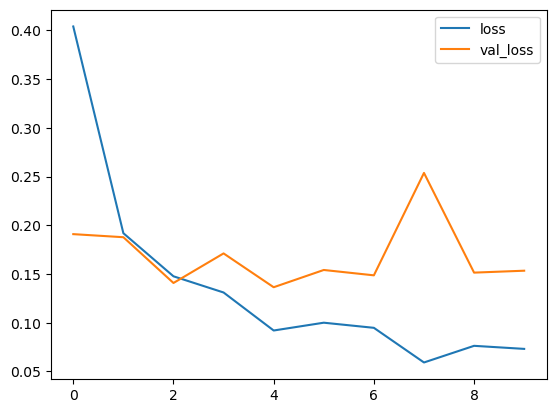

In [1207]:
plt.plot(model_history.history['loss'],label='loss')
plt.plot(model_history.history['val_loss'],label='val_loss')
plt.legend()
plt.show()

### Accuracy

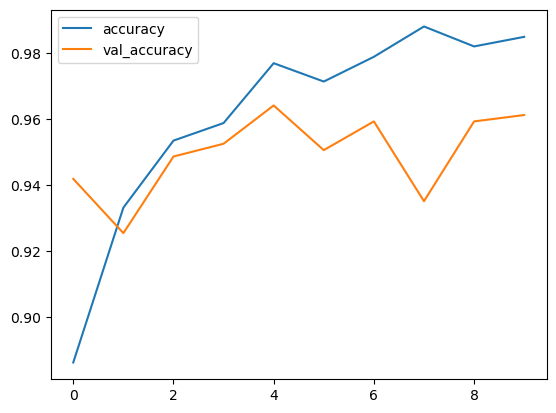

In [1208]:
plt.plot(model_history.history['accuracy'],label='accuracy')
plt.plot(model_history.history['val_accuracy'],label='val_accuracy')
plt.legend()
plt.show()

In [1209]:
prediction=model.predict(ps_data)

162/162 [==============================] - 1s 5ms/step


In [1210]:
threshold_value = 0.5

In [1211]:
prediction_summary = (prediction > threshold_value).astype(int)

In [1212]:
concatenated_array = np.concatenate((target.reshape(len(target), 1), prediction_summary.reshape(len(prediction_summary), 1)), 1)

In [1213]:
np.set_printoptions(threshold=np.inf)

In [1214]:
concatenated_array

array([[0, 0],
       [0, 0],
       [1, 1],
       [0, 0],
       [0, 0],
       [1, 1],
       [0, 0],
       [0, 0],
       [1, 1],
       [1, 1],
       [0, 0],
       [1, 1],
       [1, 1],
       [0, 0],
       [0, 0],
       [1, 1],
       [0, 0],
       [0, 0],
       [0, 0],
       [1, 1],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [1, 1],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [1, 1],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [1, 1],
       [0, 0],
       [1, 1],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [1, 1],
       [0,

In [1215]:
common_words = FreqDist(word_list).most_common(50)

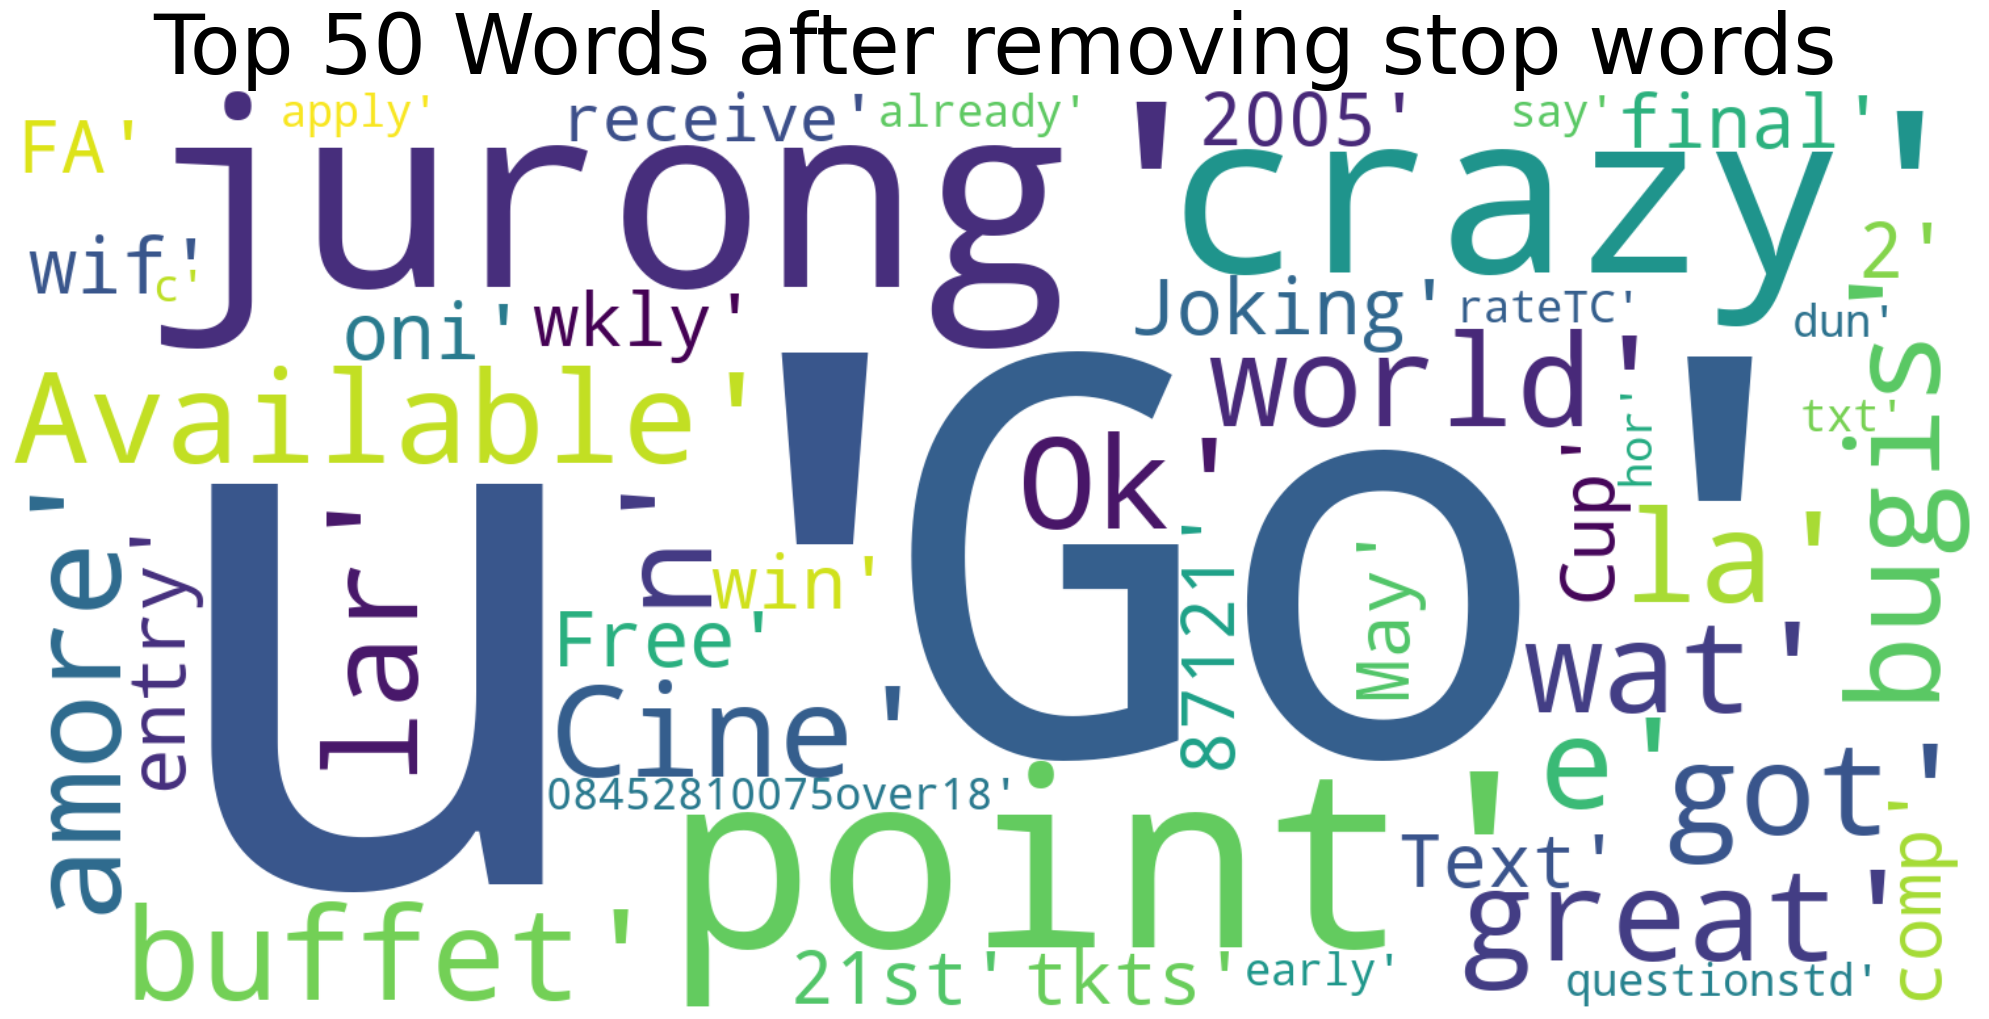

In [1216]:


wordcloud = WordCloud(width=1500, height=700, background_color='white').generate(str(common_words))
fig = plt.figure(figsize=(40,10), facecolor='white')
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Top 50 Words after removing stop words', fontsize=60)
plt.tight_layout(pad=0)
plt.show()



## Performance Metrics

In [1227]:
from keras.metrics import Precision, Recall ,Accuracy
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.metrics import roc_auc_score

In [1220]:
#AUC Score
roc =roc_auc_score(target,prediction)
print("ROC_AUC_SCORE:", roc)

ROC_AUC_SCORE: 0.9692280094460803


In [1221]:
#Root Mean Squared Error
from math import sqrt
rmse = sqrt(mean_squared_error(target, prediction_summary))
print("RMSE:", rmse)

RMSE: 0.1251812383146978


In [1222]:
#Mean Squared Error
mse = mean_squared_error(target,prediction_summary)
print("MSE:", mse)

MSE: 0.01567034242600116


In [1223]:
# Create Precision and Recall metrics
precision = Precision()
recall = Recall()
accuracy = Accuracy()

precision.update_state(target, prediction_summary)
recall.update_state(target, prediction_summary)
accuracy .update_state(target, prediction_summary)


precision_result = precision.result().numpy()
recall_result = recall.result().numpy()
accuracy_result = accuracy.result().numpy()


In [1224]:
# display precision and recall values
print(f"Precision: {precision_result}")
print(f"Recall: {recall_result}")
print(f"Accuracy: {accuracy_result}")

Precision: 0.971947193145752
Recall: 0.9019908308982849
Accuracy: 0.9843296408653259


In [1228]:
print(classification_report(target, prediction_summary))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      4516
           1       0.97      0.90      0.94       653

    accuracy                           0.98      5169
   macro avg       0.98      0.95      0.96      5169
weighted avg       0.98      0.98      0.98      5169



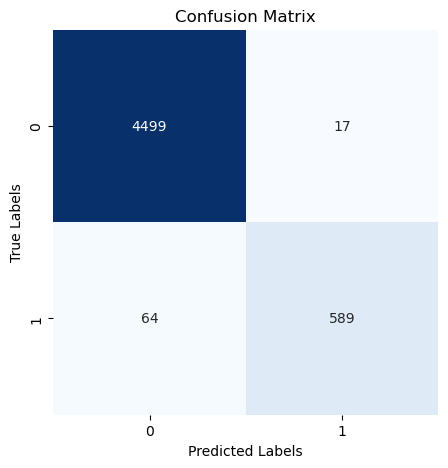

In [1225]:
cm = confusion_matrix(target, prediction_summary)

# Visualize the confusion matrix
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, square=True)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()